# This notebook contains plots of features distribuition against target



In [101]:
!pip install -q kaggle
from google.colab import files
files.upload()

{}

In [102]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [103]:
!kaggle datasets download -d sneakysnake/dmtm-dataset
!mkdir dmtm-dataset
!unzip dmtm-dataset.zip -d dmtm-dataset

dmtm-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘dmtm-dataset’: File exists
Archive:  dmtm-dataset.zip
replace dmtm-dataset/submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace dmtm-dataset/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [104]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from numpy import argmax


import warnings
warnings.filterwarnings('ignore')

In [105]:
class data_container:
    """container class for a dataset"""

    def __init__(self, dataset, drop=True):

        self._dataset = dataset

        df = self._dataset.copy()

        df['DATE'] = pd.to_datetime(df['DATE'])

        weather_names = ['_temperature_', '_rain_mm_', '_humidity_', '_wind_speed_', '_pressure_']

        for name in weather_names:
            df['max' + name + 'prev14d'] = df['max' + name + 'prev7d']
            df['max' + name + 'prev7d_shift'] = df['max' + name + 'prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', 'max' + name + 'prev14d'] = df[df['DATE'] > '2019-04-16'][
                ['max' + name + 'prev7d', 'max' + name + 'prev7d_shift']].max(axis=1)
            df = df.drop(columns=['max' + name + 'prev7d_shift'])

            df['min' + name + 'prev14d'] = df['min' + name + 'prev7d']
            df['min' + name + 'prev7d_shift'] = df['min' + name + 'prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', 'min' + name + 'prev14d'] = df[df['DATE'] > '2019-04-16'][
                ['min' + name + 'prev7d', 'min' + name + 'prev7d_shift']].min(axis=1)
            df = df.drop(columns=['min' + name + 'prev7d_shift'])

            df['mean' + name + 'prev14d'] = df['mean' + name + 'prev7d']
            df['mean' + name + 'prev7d_shift'] = df['mean' + name + 'prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', 'mean' + name + 'prev14d'] = df[df['DATE'] > '2019-04-16'][
                ['mean' + name + 'prev7d', 'mean' + name + 'prev7d_shift']].mean(axis=1)
            df = df.drop(columns=['mean' + name + 'prev7d_shift'])

        persistance_names = ['equipment', 'fire/smoke', 'ge', 'power', 'temperature']

        for name in persistance_names:
            df[name + '_max_persistance_prev14d'] = df[name + '_max_persistance_prev7d']
            df[name + '_max_persistance_prev7d_shift'] = df[name + '_max_persistance_prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', name + '_max_persistance_prev14d'] = df[df['DATE'] > '2019-04-16'][
                [name + '_max_persistance_prev7d', name + '_max_persistance_prev7d_shift']].max(axis=1)
            df = df.drop(columns=[name + '_max_persistance_prev7d_shift'])

            df[name + '_min_persistance_prev14d'] = df[name + '_min_persistance_prev7d']
            df[name + '_min_persistance_prev7d_shift'] = df[name + '_min_persistance_prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', name + '_min_persistance_prev14d'] = df[df['DATE'] > '2019-04-16'][
                [name + '_min_persistance_prev7d', name + '_min_persistance_prev7d_shift']].min(axis=1)
            df = df.drop(columns=[name + '_min_persistance_prev7d_shift'])

            df[name + '_mean_persistance_prev14d'] = df[name + '_mean_persistance_prev7d']
            df[name + '_mean_persistance_prev7d_shift'] = df[name + '_mean_persistance_prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', name + '_mean_persistance_prev14d'] = df[df['DATE'] > '2019-04-16'][
                [name + '_mean_persistance_prev7d', name + '_mean_persistance_prev7d_shift']].mean(axis=1)
            df = df.drop(columns=[name + '_mean_persistance_prev7d_shift'])

        self._temperature_cols =[col for col in df.columns if 'temperature' in col and 'alarms' not in col and 'persistance' not in col]
        self._humidity_cols = [col for col in df.columns if 'humidity' in col]
        self._wind_cols = [col for col in df.columns if 'wind' in col]
        self._rain_cols = [col for col in df.columns if 'rain' in col]
        self._alarm_cols = [col for col in df.columns if 'alarm' in col]
        self._pressure_cols = [col for col in df.columns if 'pressure' in col]
        self._persistance_cols = [col for col in df.columns if 'persistance' in col]
        self._aircon_cols = [col for col in df.columns if 'wo_prev' in col]

        self._numerical_features = self._temperature_cols + self._humidity_cols + \
                                   self._wind_cols + self._rain_cols + self._alarm_cols + \
                                   self._pressure_cols + self._persistance_cols + self._aircon_cols
        
        
        
        # process data feature
        df['month'] = df['DATE'].dt.month
        df['day'] = df['DATE'].dt.day
        df['year'] = df['DATE'].dt.year % 2019
        df['day' + '_sin'] = np.sin(2 * np.pi * df['day']/df['day'].max())
        df['day' + '_cos'] = np.cos(2 * np.pi * df['day']/df['day'].max())
        
        cell_type = [col for col in df.columns if 'CELL_TYPE' in col]
        df = df.drop(columns=cell_type)
        df = df.drop(columns='day')
        
        if drop == True:
            # drop unused columns
            df = df.drop(columns=['DATE', 'SITE_ID'])
        
        self._prepared_dataset = df
            
    @property
    def prepared_dataset(self):
        """returns a copy of the dataset ready to be passed to the model"""
        return self._prepared_dataset

    @property
    def dataset(self):
        return self._dataset

    @property
    def numerical_features(self):
        return self._numerical_features

    def features_by_type(self, features=None, dataset_type='prepared'):
        """returns a DataFrame with the selected features (temperature, humidity, wind, rain)"""
        if features == None:
            return None

        elif features in ['temperature', 'humidity', 'wind', 'rain', 'pressure']:
            cols = [i for i in self.dataset.columns if features in i]

            if dataset_type == 'prepared':
                return self.prepared_dataset[cols]

            elif dataset_type == 'raw':
                return self.dataset[cols]

        return None



In [106]:
import matplotlib.gridspec as gridspec
def plot_distributions(start, stop, grid_spec_rows, gridspec_columns, figsize=(22, 15)):
  plt.figure(figsize=figsize)

  features = df2.iloc[:,start:stop].columns
  gs = gridspec.GridSpec(grid_spec_rows, gridspec_columns)
  for i, feature in enumerate(df2[features]):
      ax = plt.subplot(gs[i])
      sns.distplot(df2[feature][df2.aircon_sum_target_next14d == 1], bins=50)
      sns.distplot(df2[feature][df2.aircon_sum_target_next14d == 0], bins=50)
      ax.set_xlabel('')
      ax.set_title('Feature: ' + str(feature))

In [107]:
train = pd.read_csv('dmtm-dataset/train.csv')

In [108]:
container = data_container(train)
df = container.dataset
df2 = df.drop(columns='aircon_sum_target_next14d')
df2['aircon_sum_target_next14d'] = df['aircon_sum_target_next14d']

df2['DATE'] = pd.to_datetime(df2['DATE'])

In [109]:
df2.columns[18:21]

Index(['aircon_sum_wo_prev7d', 'aircon_sum_wo_prev14d',
       'mean_temperature_prev7d'],
      dtype='object')

# Cell type

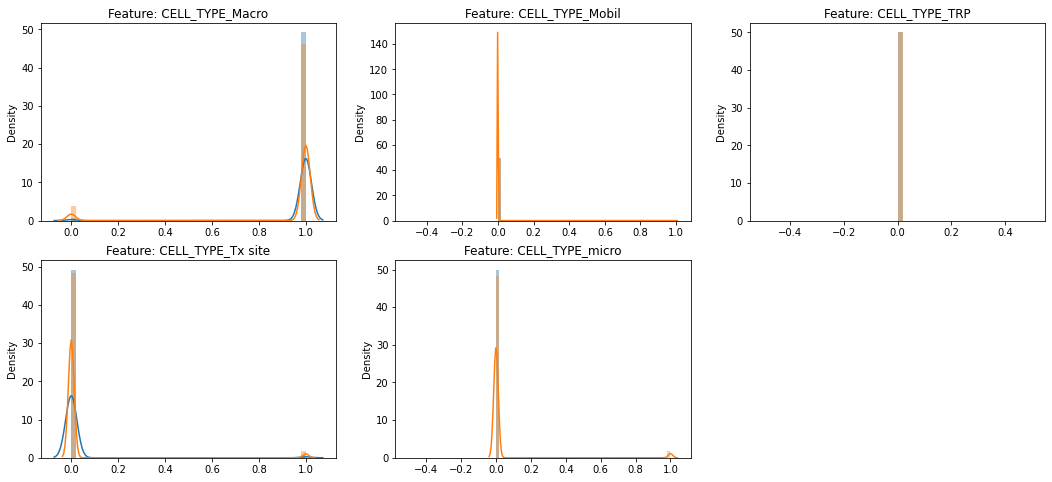

In [110]:
plot_distributions(2, 7, 2, 3, (18, 8))

# target precedent 7 and 14 days

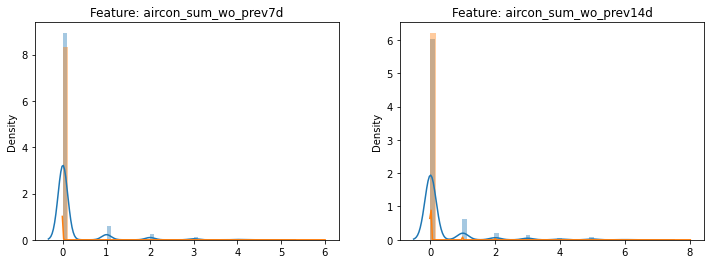

In [111]:
plot_distributions(18, 20, 1, 2, (12, 4))

# transported sites and clusters 

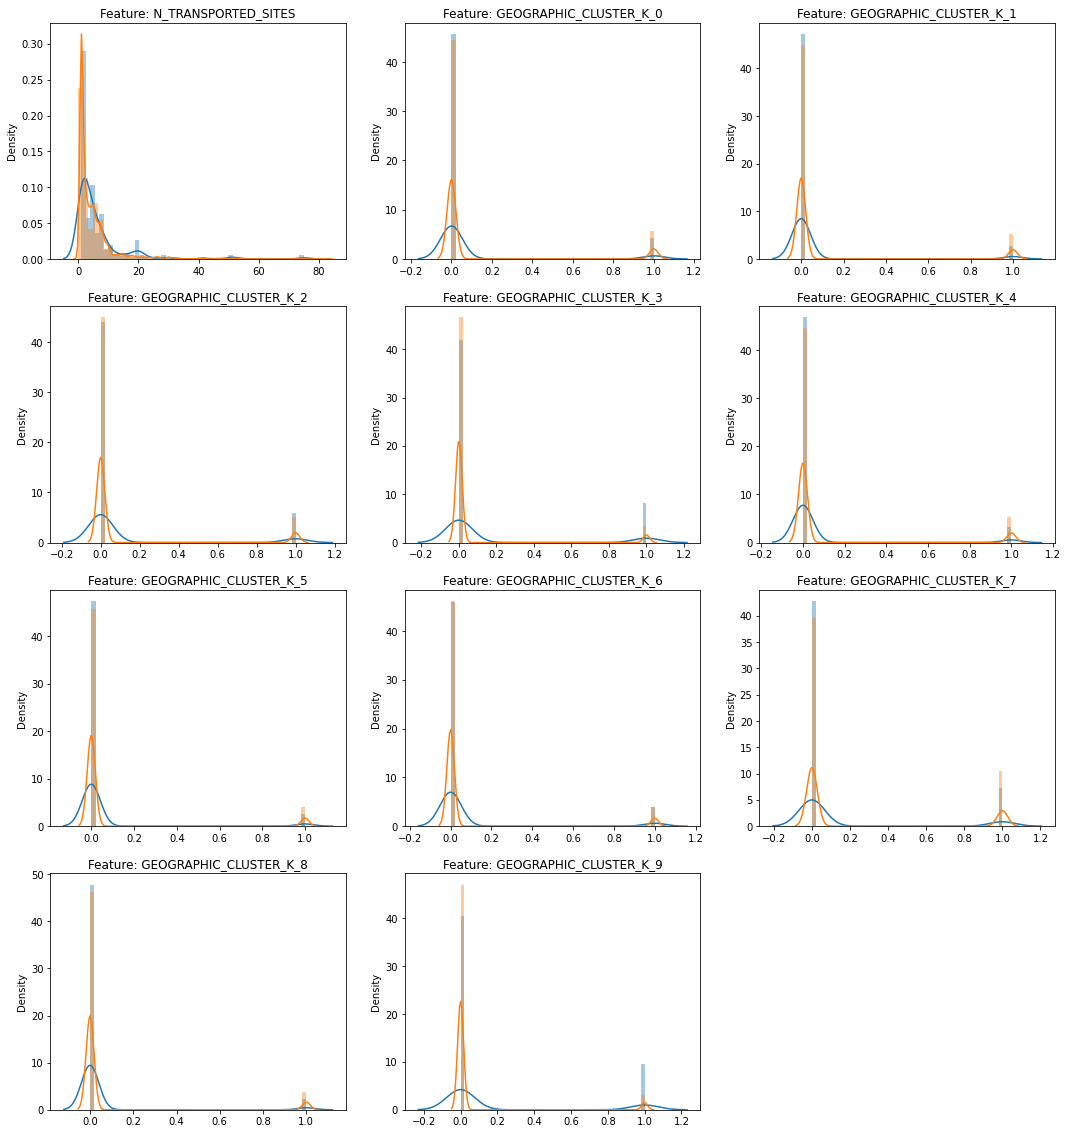

In [112]:
plot_distributions(7, 18, 4, 3, (18, 20))

# Temperature

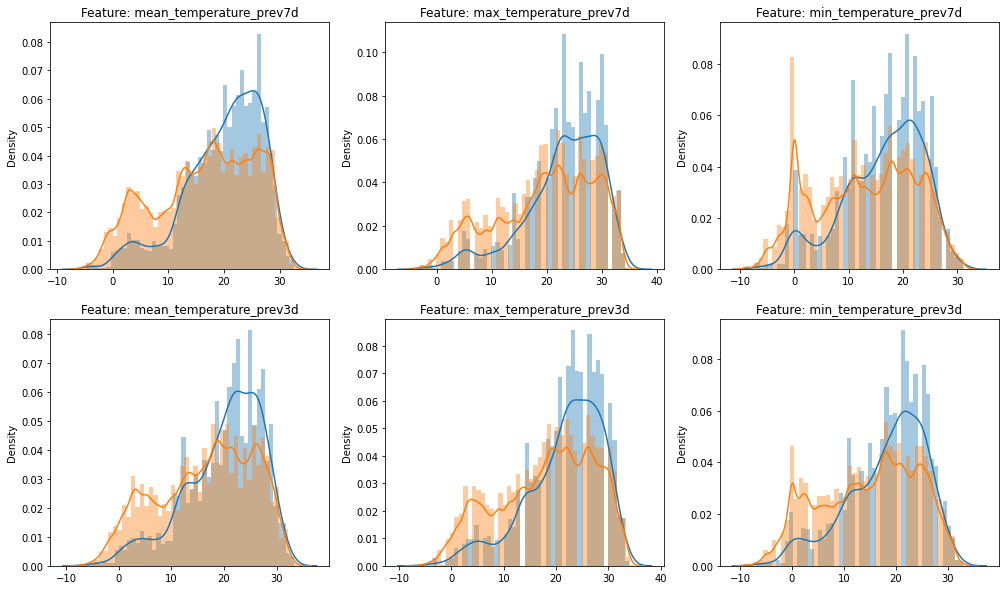

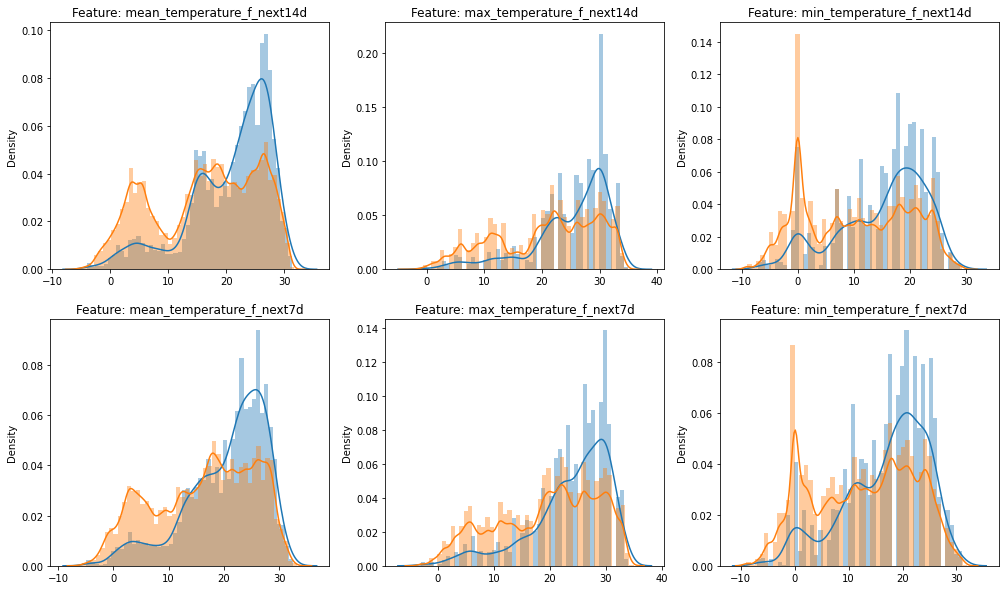

In [113]:
plot_distributions(20, 26, 2, 3, (17,10))
plot_distributions(50, 56, 2, 3, (17,10))

# Rain

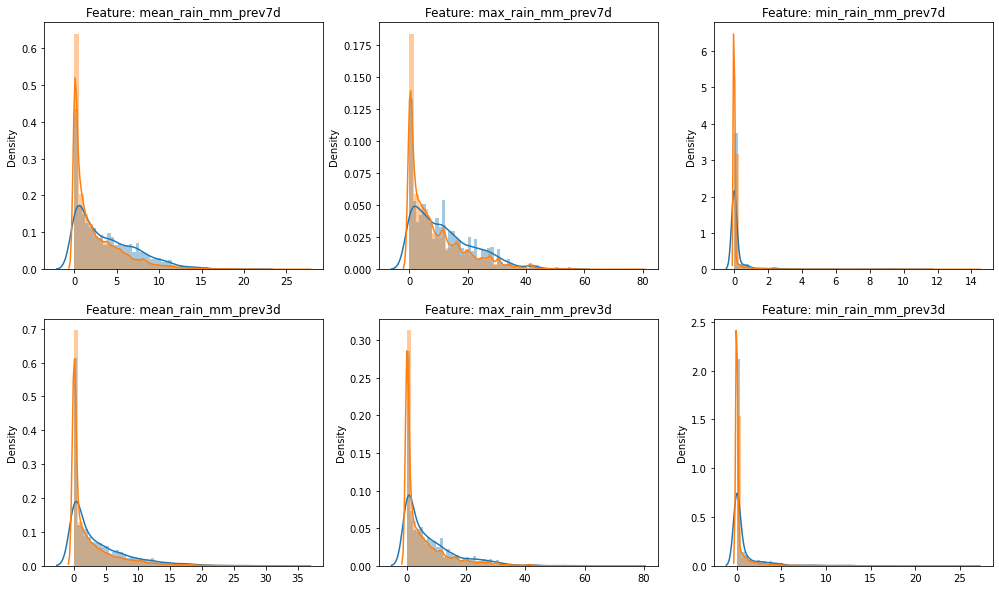

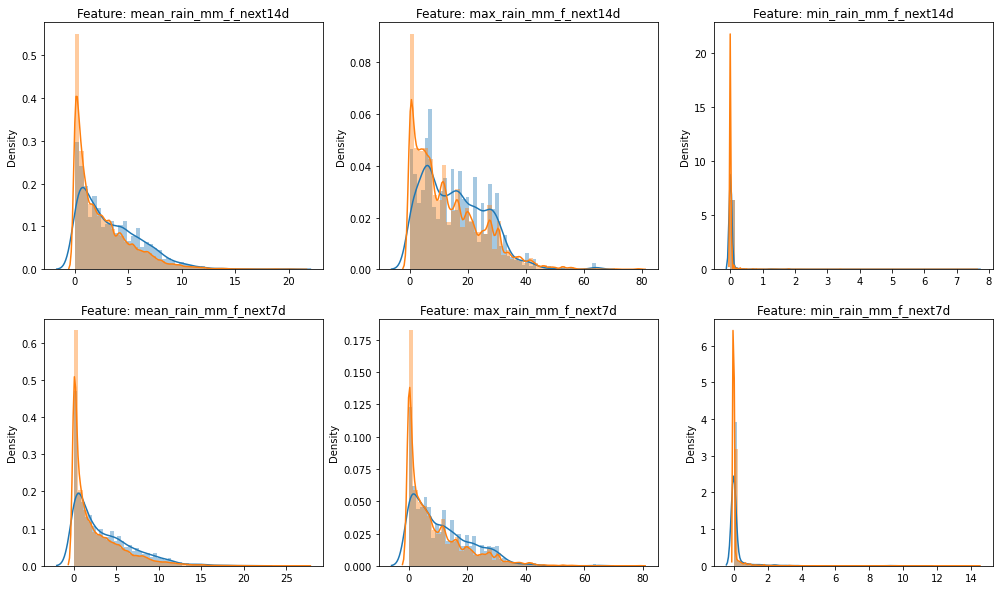

In [114]:
plot_distributions(26, 32, 2, 3, (17,10))
plot_distributions(56, 62, 2, 3, (17,10))

# Humidity

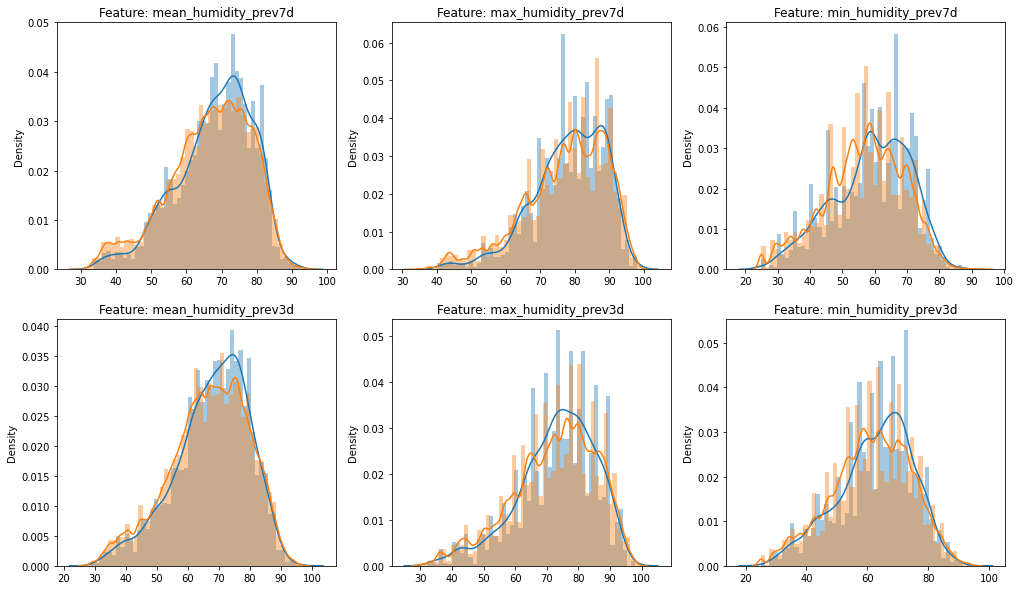

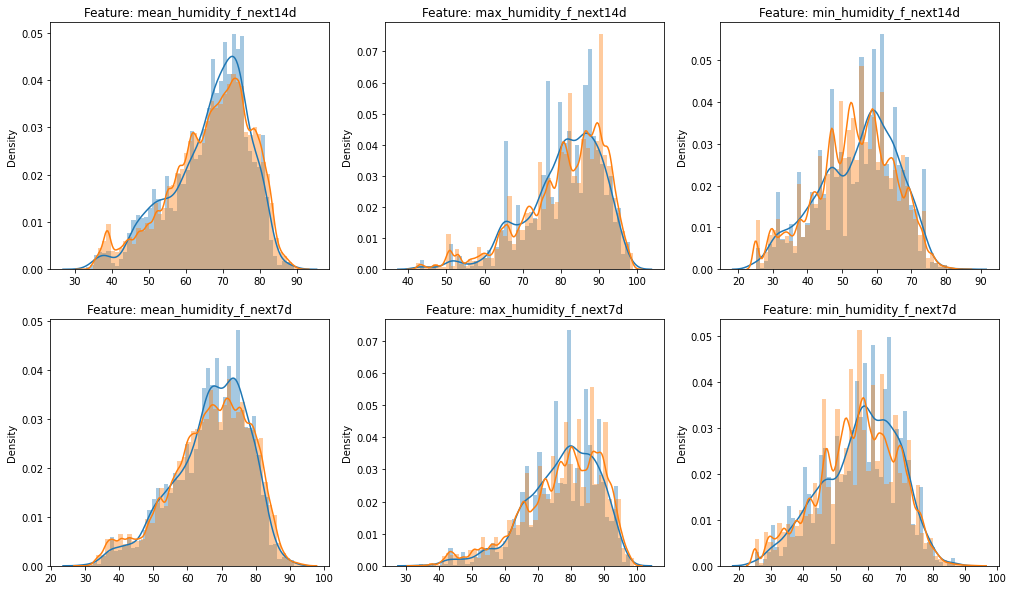

In [115]:
plot_distributions(32, 38, 2, 3, (17,10))
plot_distributions(62, 68, 2, 3, (17,10))

# Wind

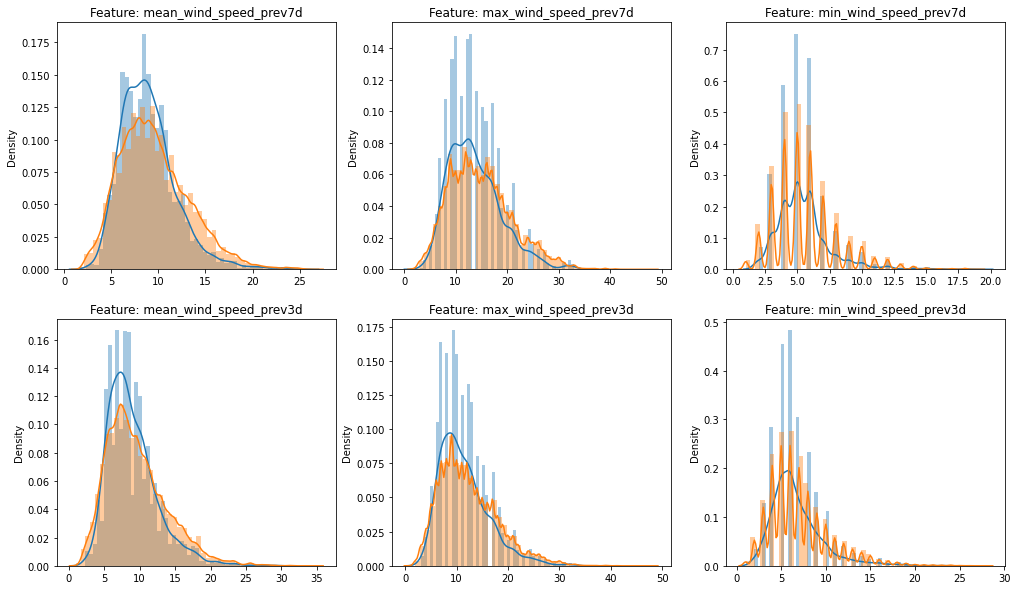

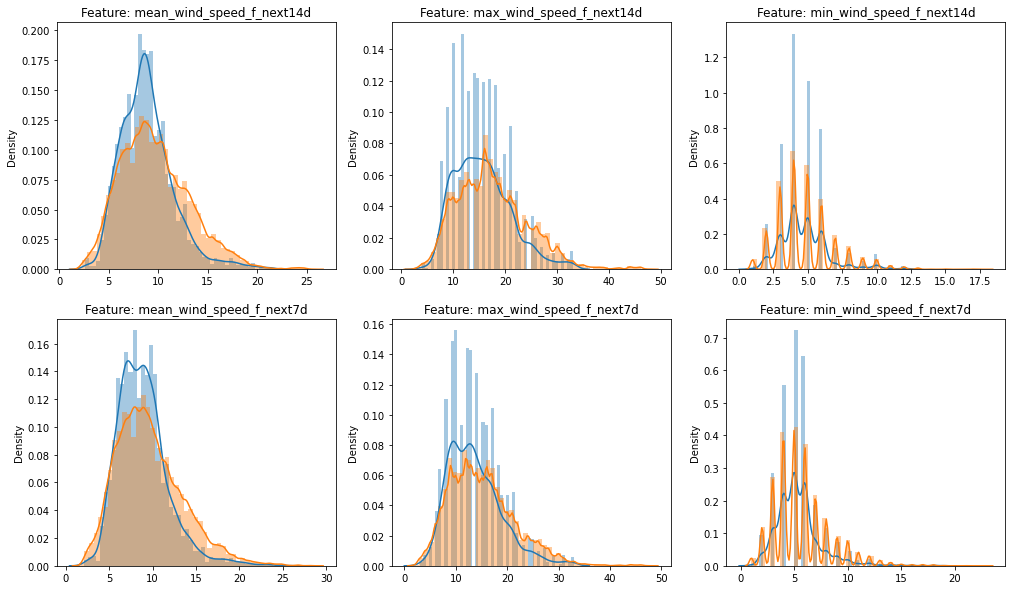

In [116]:
plot_distributions(38, 44, 2, 3, (17,10))
plot_distributions(68, 74, 2, 3, (17,10))

# Pressure

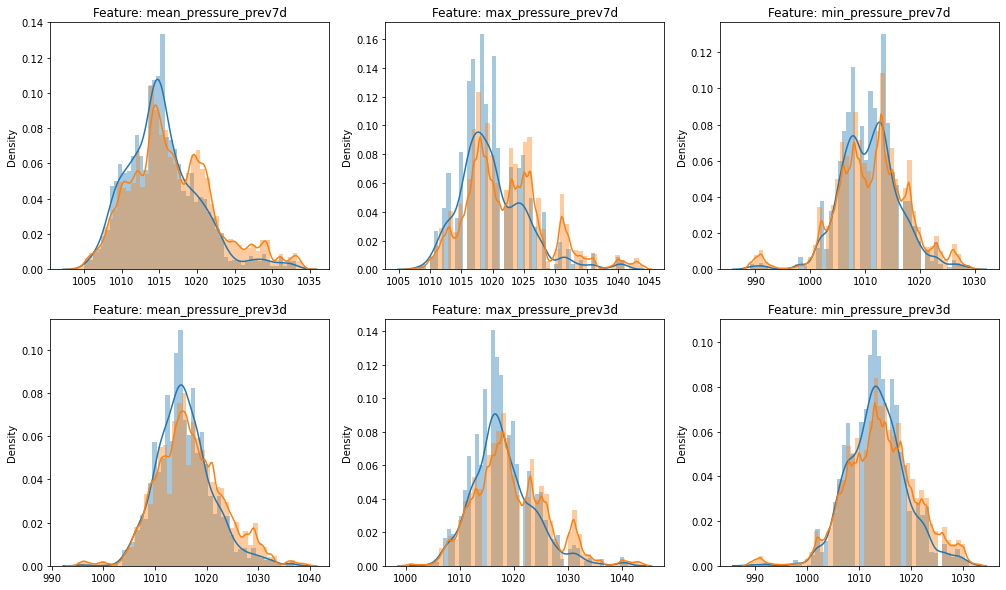

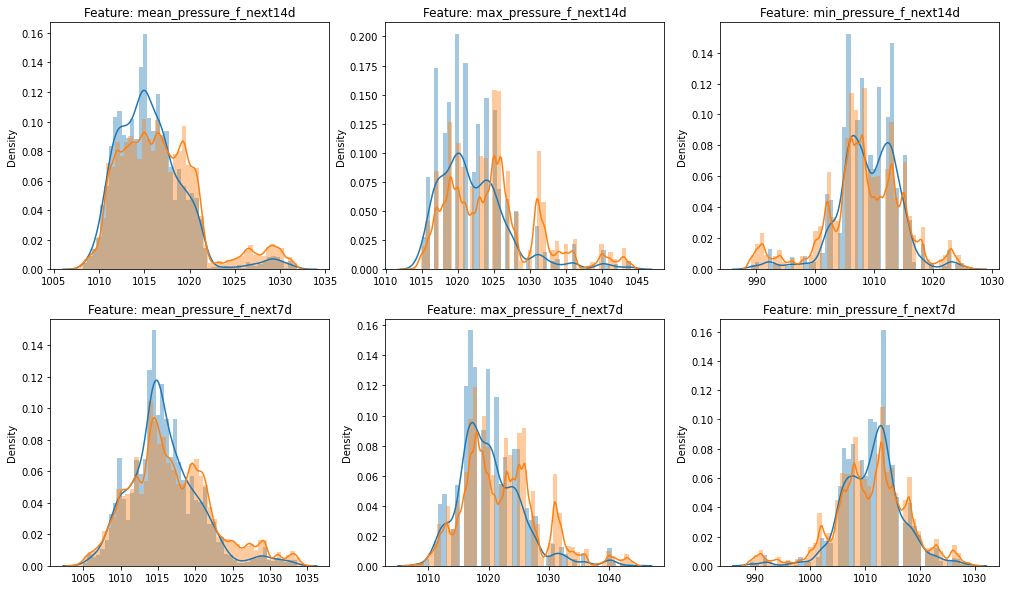

In [117]:
plot_distributions(44, 50, 2, 3, (17,10))
plot_distributions(74, 80, 2, 3, (17,10))

# Equipment sum alarms

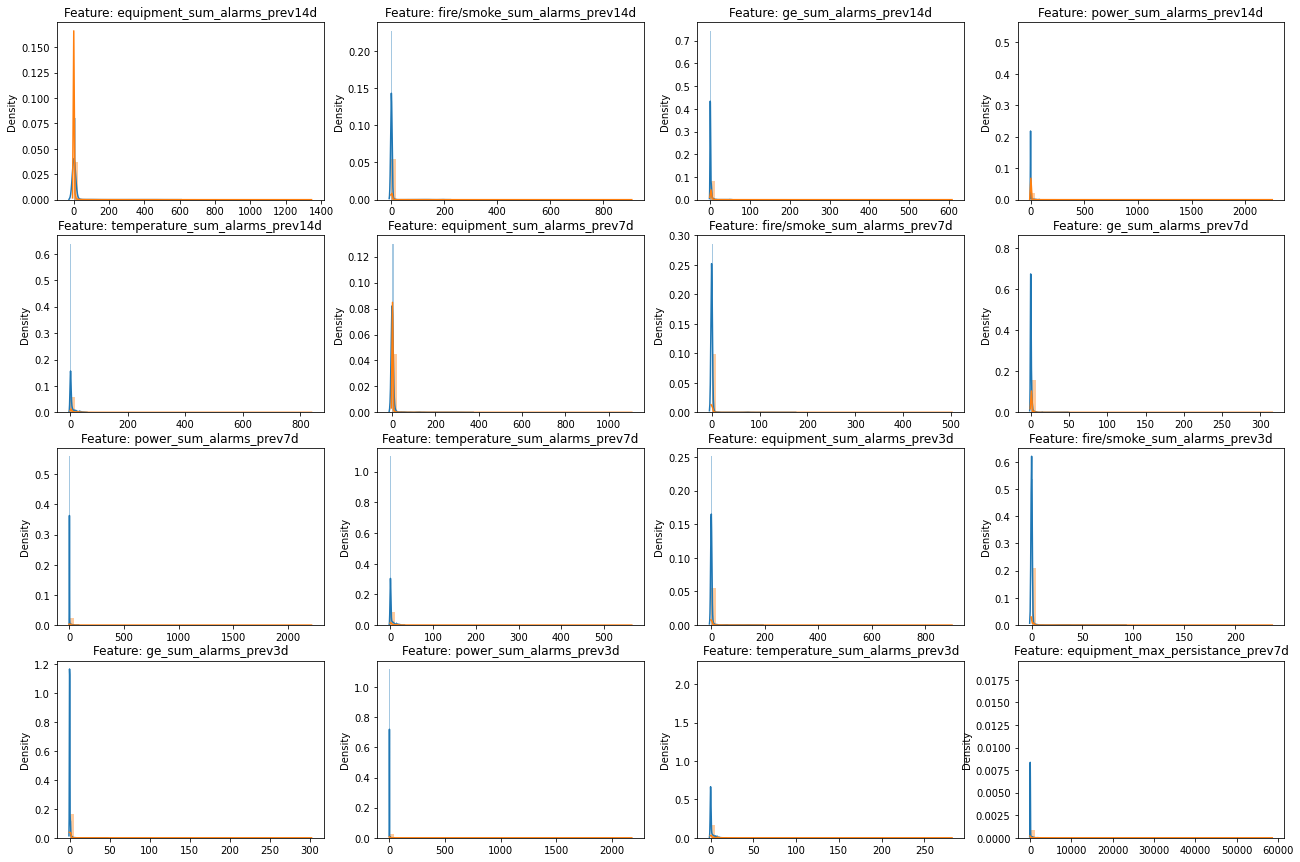

In [118]:
plot_distributions(80, 96, 4, 4)

# Equipment alarms persistence

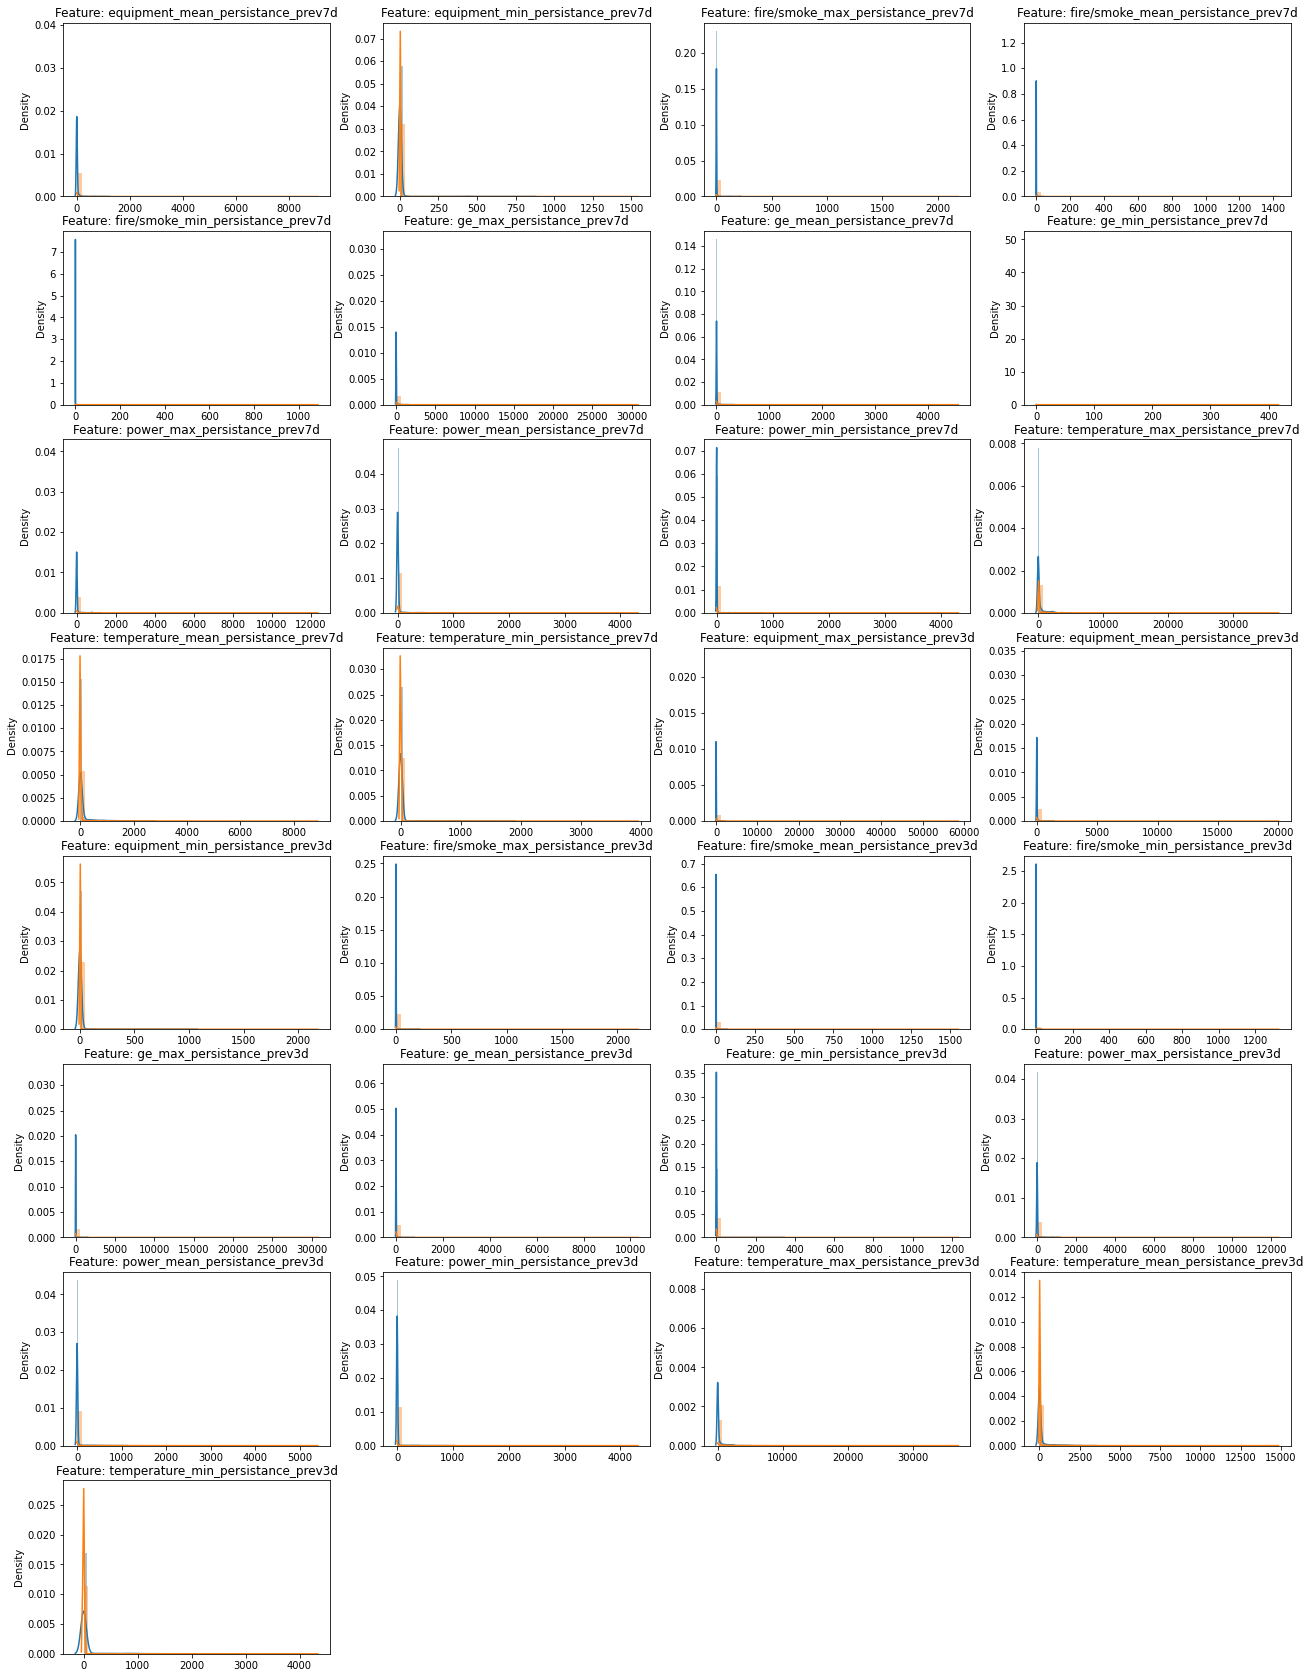

In [119]:
plot_distributions(96, 125, 8, 4, (22, 30))

# Skew 

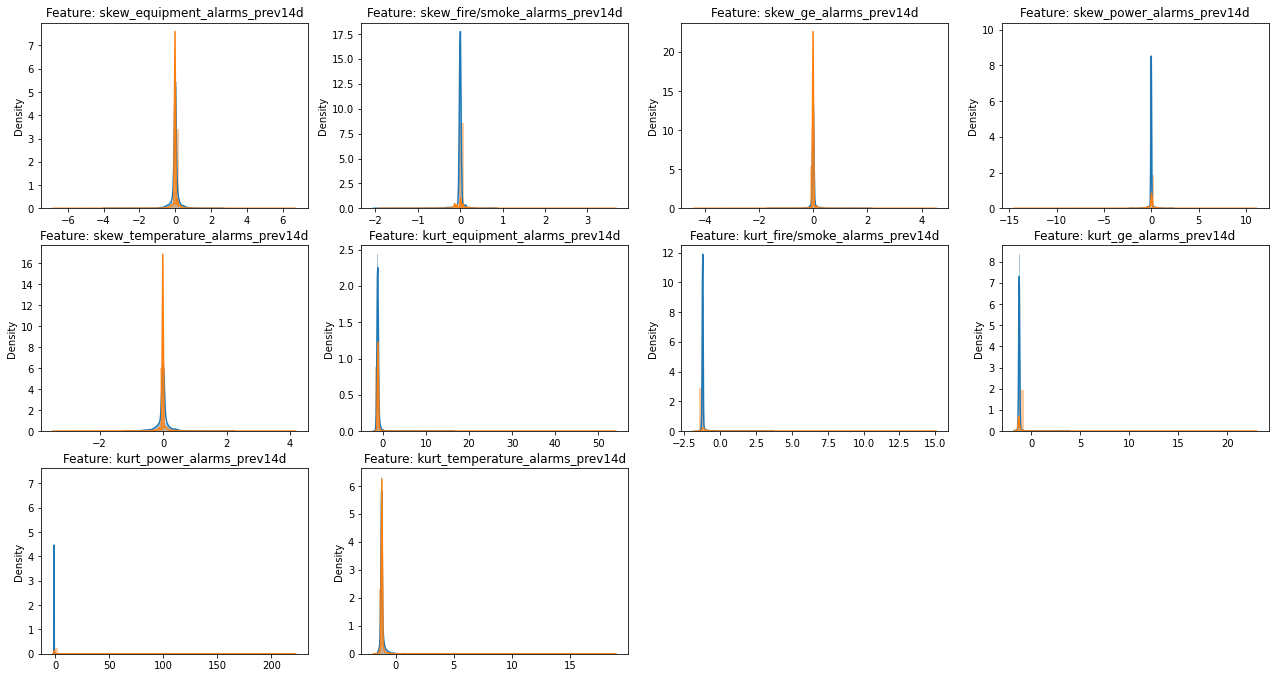

In [120]:
plot_distributions(125, 135, 7, 4, (22, 28))